## Crystals
---

Crystalline solids have multiple peculiarities connected with their fundamental property: discrete translational symmetry. Additionally, they exhibit additional symmetries which influence their properties (e.g. electronic band structure) as well as procedures used in the calculation. Dealing with crystals require use of Periodic Boundary Conditions and, often, reciprocal space, Brillouin Zone etc. ASE provides multiple tools for working with crystals. We will use some of them in the following examples - which is modeled after one of the AbInit tutorials.

In the following exercise we will:
* build a crystal of Silicon,
* calculate its lattice parameters,
* derive its electronic band structure.

As usual the detailed technical documentation regarding ASE toolbox can be found [ASE documentation site](https://wiki.fysik.dtu.dk/ase/index.html). The documentation concerning the DFT tool used in the exercise is located at [AbInit documentation site](https://docs.abinit.org/).

In [ ]:
%pylab inline
from ase.build import bulk
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.calculators.abinit import Abinit
import ase.io
from ase import units as un
import os

# Patch bug in ASE AbInit interface
import ase_patch
ase.io.abinit.read_abinit_out = ase_patch.read_abinit_out

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Building the Silicon crystal

The silicon has a simple crystal structure with two atoms per primitive unit cell - in fact it is the same structure as diamond. Thus, building the structure is almost trivial - the only free parameter is the length of the lattice vector $a$.

In [ ]:
Si = bulk('Si', crystalstructure='diamond', a=5.4)
print(Si.cell.cellpar())

[ 3.81837662  3.81837662  3.81837662 60.         60.         60.        ]


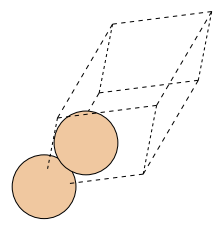

In [ ]:
ax = plot_atoms(Si, rotation='10x,20y,15z')
ax.set_axis_off()

In [ ]:
calc = Abinit(label='Si', directory="work_04", v8_legacy_format=True,
              ecut= 270,
              pps='psp8',
              toldfe=1.0e-6,
              diemac=12,
              nstep=20,
              kptopt=1,
              ngkpt=[2,2,2],
              nshiftk=4,
              shiftk=[[0.5, 0.5, 0.5],
                      [0.5, 0.0, 0.0],
                      [0.0, 0.5, 0.0],
                      [0.0, 0.0, 0.5]]
              )

Si.set_calculator(calc)
print(Si.get_potential_energy(), Si.get_stress()/un.GPa)

-229.759346765084 [-2.54036912 -2.54036912 -2.54036912  0.          0.          0.        ]


### Convergence

We will be scanning multiple parameters in our study. To avoid repeating the same code over and over again we will write (somewhat) universal scanning function. This function uses some more advanced Python techniques like doc-strings inside the function, basic functional programming (`lambda` expression defining anonymous function and function assignment) and passing arguments as dictionaries. You can read about these topics in the python documentation. You can experiment with this function and use it as a basis for your own tools.

In [ ]:
def scan_param(cryst, param, start=0, stop=1, steps=7, 
               lista=None, log_scale=True, int_par=False):
    '''
    Scan a range of parameter param and plot 
    '''
    fi = lambda x: x
    fo = lambda x: x

    if lista is None:
        if log_scale :
            fi = log
            fo = exp
        lista = linspace(fi(start), fi(stop), steps)
    else :
        int_par=False
    
    dat = []
    vs = []
        
    for v in lista:
        print(f'{param}={fo(v)}: ', end='')
        if int_par:
            cryst.calc.set(**{param: int(fo(v))})
        else :
            cryst.calc.set(**{param: fo(v)})
        vs.append(fo(v))
        dat.append([cryst.get_potential_energy(),
                    cryst.get_stress()[:3].mean()])
        print(f'{dat[-1][0]:.3f} eV ; {dat[-1][1]/un.GPa:6.3f} GPa',)
    dat = array(dat).T
    return vs, dat

In [ ]:
ecuts, eres = scan_param(Si, 'ecut', 250, 500)

ecut=249.9999999999999: -229.742 eV ; -2.227 GPa
ecut=280.6155120773432: -229.765 eV ; -2.641 GPa
ecut=314.9802624737181: -229.777 eV ; -2.835 GPa
ecut=353.5533905932736: -229.780 eV ; -2.876 GPa
ecut=396.85026299204986: -229.783 eV ; -2.866 GPa
ecut=445.44935907016935: -229.786 eV ; -2.881 GPa
ecut=499.99999999999983: -229.787 eV ; -2.903 GPa


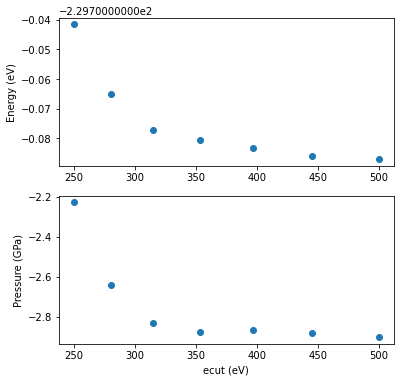

In [ ]:
figsize(6,6)
subplot(211)
plot(ecuts, eres[0], 'o')
ylabel('Energy (eV)')
subplot(212)
plot(ecuts, eres[1]/un.GPa, 'o')
ylabel('Pressure (GPa)')
xlabel('ecut (eV)');

In [ ]:
Si.calc.set(ecut=350)

{'ecut': 350}

In [ ]:
kv, kres = scan_param(Si, 'ngkpt', lista=[[1,1,1], [2,2,2], [3,3,3], [4,4,4], [5,5,5]])

ngkpt=[1, 1, 1]: -227.290 eV ; -9.352 GPa
ngkpt=[2, 2, 2]: -229.780 eV ; -2.876 GPa
ngkpt=[3, 3, 3]: -229.936 eV ; -2.486 GPa
ngkpt=[4, 4, 4]: -229.953 eV ; -2.445 GPa
ngkpt=[5, 5, 5]: -229.956 eV ; -2.445 GPa


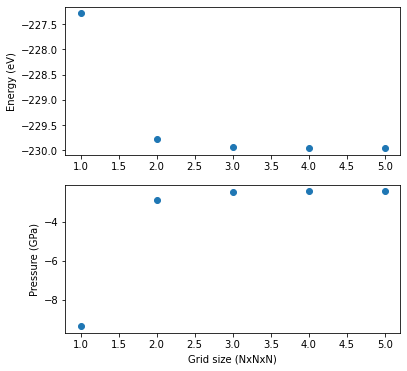

In [ ]:
subplot(211)
plot([k[0] for k in kv], kres[0], 'o')
ylabel('Energy (eV)')
subplot(212)
plot([k[0] for k in kv], kres[1]/un.GPa, 'o')
ylabel('Pressure (GPa)')
xlabel('Grid size (NxNxN)');

In [ ]:
ngp=4
Si.calc.set(ecut=350, ngkpt=[ngp, ngp, ngp])

{'ngkpt': [4, 4, 4]}

### Cell size optimization

To find optimum size of the cell we run the calculator with `optcell=1` parameter (plus some other connected parameters). After the run is finished we read-in the results and update the crystal.

In [ ]:
print('Initial cell:  ', Si.cell.cellpar())
print('Initial stress:', Si.get_stress()/un.GPa, 'GPa')

Initial cell:   [ 3.81837662  3.81837662  3.81837662 60.         60.         60.        ]
Initial stress: [-2.44493756 -2.44493756 -2.44493756  0.          0.          0.        ] GPa


In [ ]:
# Set up the calculation
Si.calc.set(optcell=1,              # Optimize cell volume
            ionmov=2,               # Update atomic positions
            ntime=20,               # Max. number of steps
            ecutsm=0.5*un.Ha,       # Energy buffer for changing basis
            chkdilatmx=0,
            )

# Run the calculation and check the result
print(Si.get_potential_energy(), Si.get_stress()[:3]/un.GPa)

-228.380489497083 [-0.00373011 -0.00373011 -0.00373011]


Update the crystal from the `Si.calc.results` dictionary and check if we have acceptable convergence by switching off optimization mode (`optcell=0`) and recalculating the stress tensor.

In [ ]:
# Update the cell matrix
Si.set_cell(Si.calc.results['atoms'].cell, scale_atoms=True)

# Reset the calculator to the *single point* mode
Si.calc.set(optcell=0, ionmov=0)

{'optcell': 0, 'ionmov': 0}

In [ ]:
print('Final cell:  ', Si.cell.cellpar())
print('Final stress:', Si.get_stress()/un.GPa, 'GPa')

Final cell:   [ 3.86738647  3.86738647  3.86738647 60.         60.         60.        ]
Final stress: [-0.00380698 -0.00380698 -0.00380698  0.          0.          0.        ] GPa


In [ ]:
print(f'Final lattice constant a = {2*Si.cell[0,2]:.4f} A')

Final lattice constant a = 5.4693 A
